In [94]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import plotting
from scipy.stats import norm

sns.set_style("whitegrid")
sns.set_context("paper", rc={
    "axes.labelsize": 20,
    "xtick.labelsize": 20
})   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# results = []
# results_dir = './20231005144659_sim_mar/results/'
# for filename in os.listdir(results_dir):
#     with open(f'{results_dir}/{filename}', 'rb') as f:
#         res = pickle.load(f).to_dict()
#         res.update(res['result'])
#         del res['result']
#         results.append(pd.Series(res))

# df = pd.DataFrame(results)
# with open('./20231005144659_sim_mar/results_all.pickle', 'wb') as f:
#     pickle.dump(df, f)

In [127]:
# 20231004145115_sim_mar
# 20231005144659_sim_mar
# 20240201000642_sim_mar

# with open(f'./results/20240130154602_sim_mar/results_all.pickle', 'rb') as f:
with open(f'./results/20240131152645_sim_mar/results_all.pickle', 'rb') as f:
    df_logchol = pickle.load(f)

with open(f'./results/20240201000642_sim_mar/results_all.pickle', 'rb') as f:
    df_ours = pickle.load(f)
    df_ours_w = df_ours[df_ours['sim_setup'] == 'wasserstein'].copy()
    df_ours_r = df_ours[df_ours['sim_setup'] == 'r'].copy()

with open(f'./results/20240201000642_sim_mar/results_all.pickle', 'rb') as f:
    df_ser_dep = pickle.load(f)
    df_ser_dep_w = df_ser_dep[df_ser_dep['sim_setup'] == 'wasserstein'].copy()
    df_ser_dep_r = df_ser_dep[df_ser_dep['sim_setup'] == 'r'].copy()


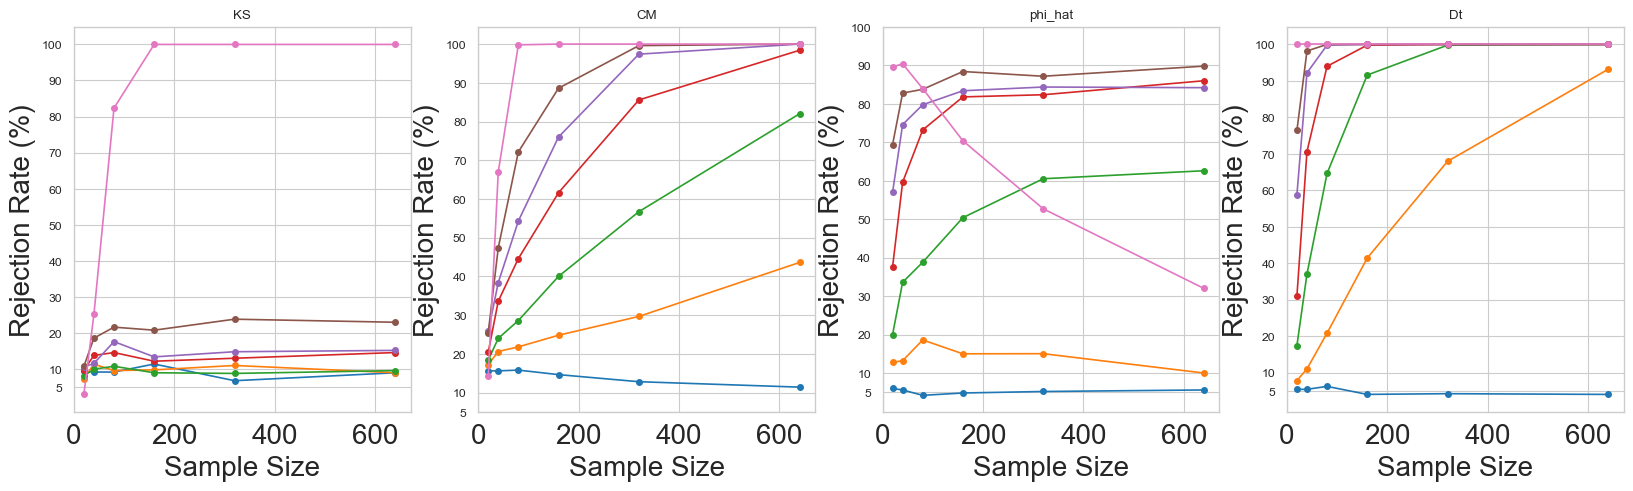

In [129]:
plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_test_for(df_ser_dep_w, 'KS', onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_test_for(df_ser_dep_w, 'CM', onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_test_for(df_ours_w, 'phi_hat', onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_test_for(df_ours_w, 'Dt')

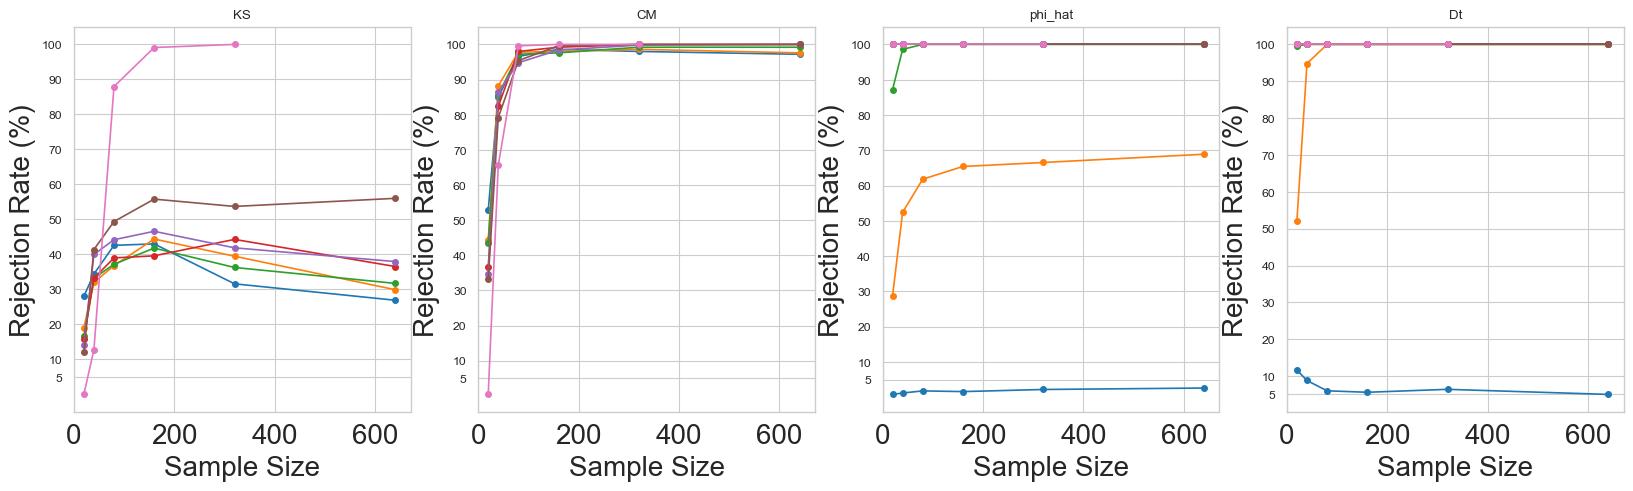

In [130]:
plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_test_for(df_logchol, 'KS', onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_test_for(df_logchol, 'CM', onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_test_for(df_logchol, 'phi_hat', onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_test_for(df_logchol, 'Dt')

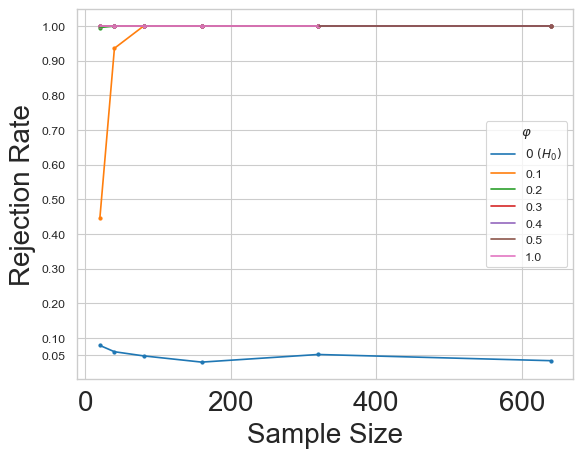

In [131]:
def plot_test_for(df, statname):
    h0_m = df[f'quantiles_{statname}'].apply(np.mean)
    h0_s = df[f'quantiles_{statname}'].apply(np.std)
    z = (df[statname] - h0_m) / h0_s

    df['rejected'] = np.abs(z) > 1.96

    results = df.groupby(['sample_size', 'phi']).agg(rejection_rate=('rejected', 'mean')).reset_index()

    for phi in results.phi.unique():
        sub_df = results[results['phi'] == phi]

        plt.scatter(sub_df['sample_size'], sub_df.rejection_rate, s=5)
        if phi == 0:
            plt.plot(sub_df['sample_size'], sub_df.rejection_rate, label=r'$0\ (H_0)$')
        else:
            plt.plot(sub_df['sample_size'], sub_df.rejection_rate, label=np.round(phi,1))
    plt.xlabel('Sample Size')
    plt.ylabel('Rejection Rate')
    plt.legend(title=r'$\varphi$')
    plt.grid('on')
    plt.yticks([0.05,0.1,0.2,0.3,0.4,0.5,0.6,.7,.8,.9,1]);

plot_test_for(df_logchol, 'Dt')

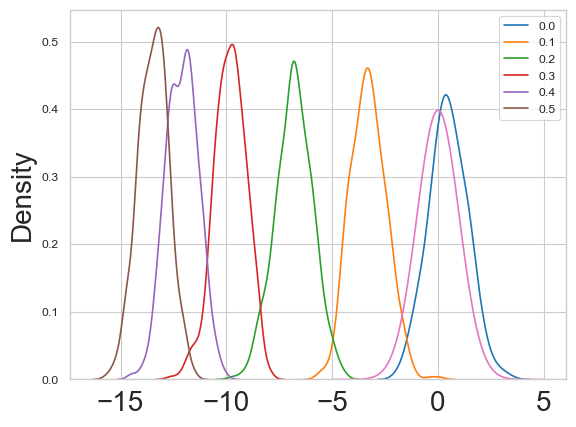

In [132]:
import seaborn as sns

T = 40
for phi in np.sort(df_logchol.phi.unique()):
    if phi == 1:
        continue

    sub_df = df_logchol[(df_logchol['phi'] == phi) & (df_logchol['Dt'] < 100) & (df_logchol['sample_size'] == T)]

    e = sub_df['quantiles_Dt'].apply(np.mean)
    s = sub_df['quantiles_Dt'].apply(np.std)
    z = (sub_df.Dt-e)/s
    
    sns.kdeplot(z, label=phi)

plt.plot(np.linspace(-5,5,100), norm.pdf(np.linspace(-5,5,100)))
plt.legend()

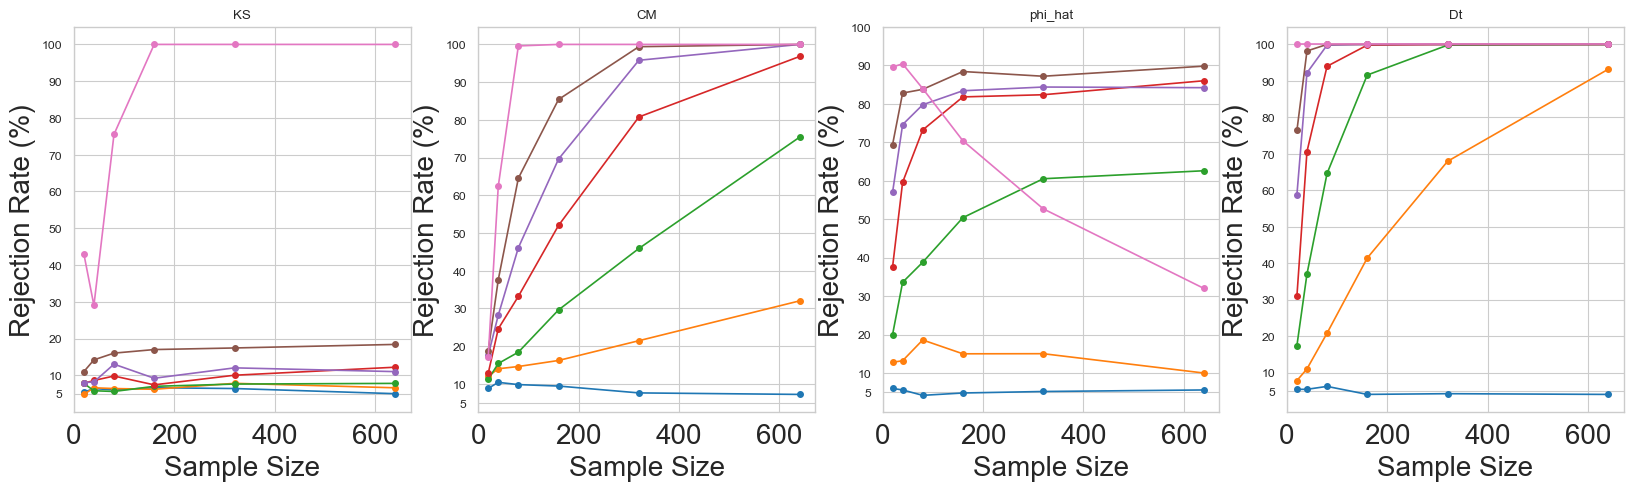

In [133]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_test_for(df_ser_dep_w, 'KS')
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_test_for(df_ser_dep_w, 'CM')


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_test_for(df_ours_w, 'phi_hat', onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_test_for(df_ours_w, 'Dt')

In [21]:
def plot_alpha_alpha(df, statname, samplesize, onesided=False):
    target_sizes = np.linspace(0, 0.1, 40)
    for phi in [0]: # np.sort(df.phi.unique()):
        sub_df = df[(df['sample_size'] == samplesize) & (df['phi'] == phi)]

        emp_sizes = np.zeros_like(target_sizes)
        for i in range(target_sizes.shape[0]):
            alpha=target_sizes[i]

            if onesided:
                crit = compute_critical_val(sub_df, f'quantiles_{statname}', 1-alpha)
                emp_sizes[i] = (sub_df[statname] > crit).mean()
            else:
                crit_lo = compute_critical_val(sub_df, f'quantiles_{statname}', alpha/2)
                crit_hi = compute_critical_val(sub_df, f'quantiles_{statname}', 1 - alpha/2)
                emp_sizes[i] = ((sub_df[statname] < crit_lo) | (sub_df[statname] > crit_hi)).mean()
            
        label = r'$0\ (H_0)$' + statname if phi == 0 else f'{phi:.1f}'
        plt.scatter(target_sizes, emp_sizes, label=label, s=5)

    
    plt.plot(target_sizes,target_sizes)
    plt.legend(title=r'$\varphi$')
    plt.xlabel('Test level')
    plt.ylabel('Rejection Rate')
    plt.grid('on')

samplesize = 320

plot_alpha_alpha(df_ser_dep_w, 'KS', samplesize, onesided=True)
plot_alpha_alpha(df_ser_dep_w, 'CM', samplesize, onesided=True)


plot_alpha_alpha(df_ours_w, 'phi_hat', samplesize, onesided=True)

plot_alpha_alpha(df_ours_w, 'Dt', samplesize)


NameError: name 'compute_critical_val' is not defined

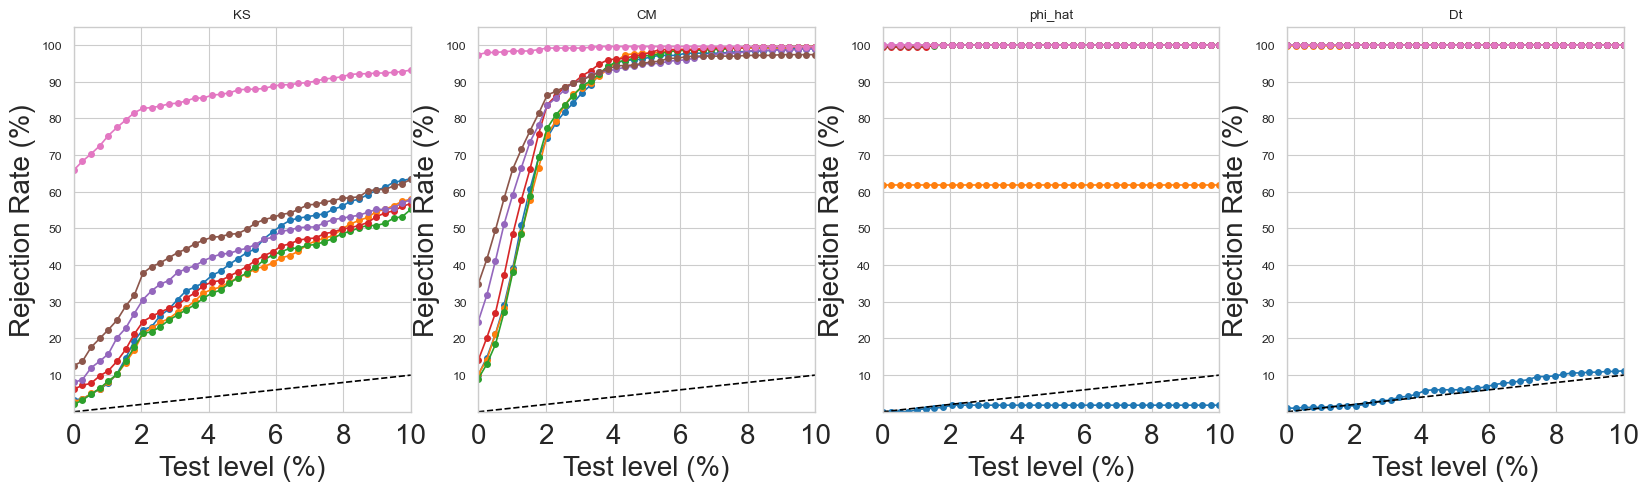

In [134]:

samplesize = 80

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_alpha_alpha(df_logchol, 'KS', samplesize, onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_alpha_alpha(df_logchol, 'CM', samplesize, onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_alpha_alpha(df_logchol, 'phi_hat', samplesize, onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_alpha_alpha(df_logchol, 'Dt', samplesize)


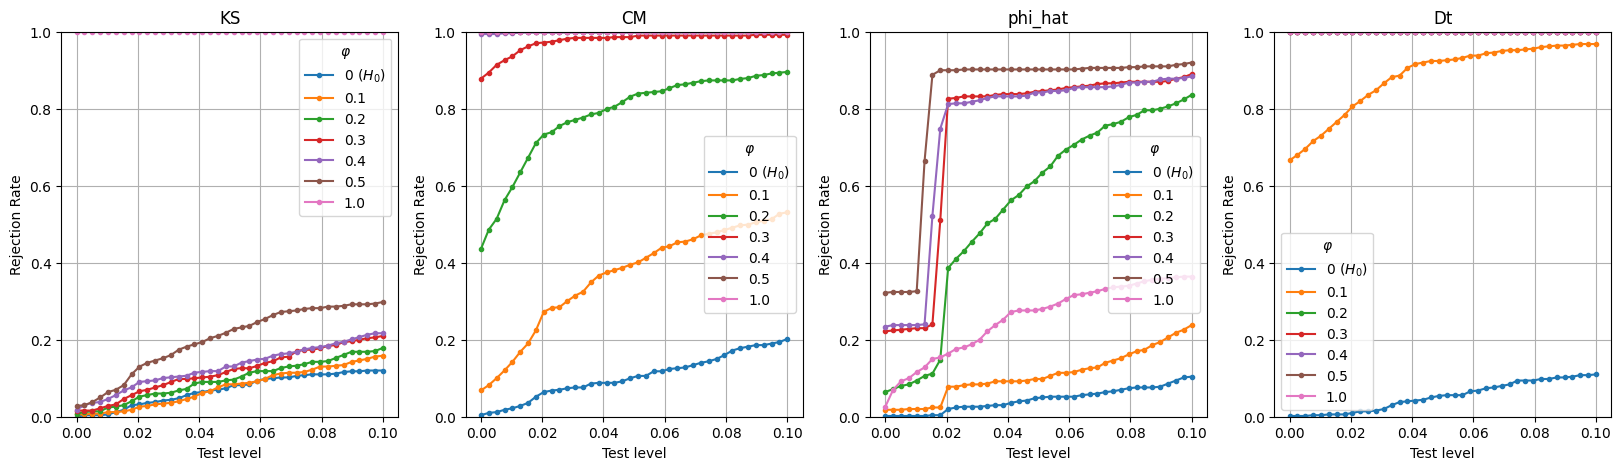

In [66]:

samplesize = 640

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_alpha_alpha(df_ser_dep_w, 'KS', samplesize, onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_alpha_alpha(df_ser_dep_w, 'CM', samplesize, onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_alpha_alpha(df_ours_w, 'phi_hat', samplesize, onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
# plt.plot(np.linspace(0, .1, 40),np.linspace(0, .1, 40))
plotting.plot_alpha_alpha(df_ours_w, 'Dt', samplesize)


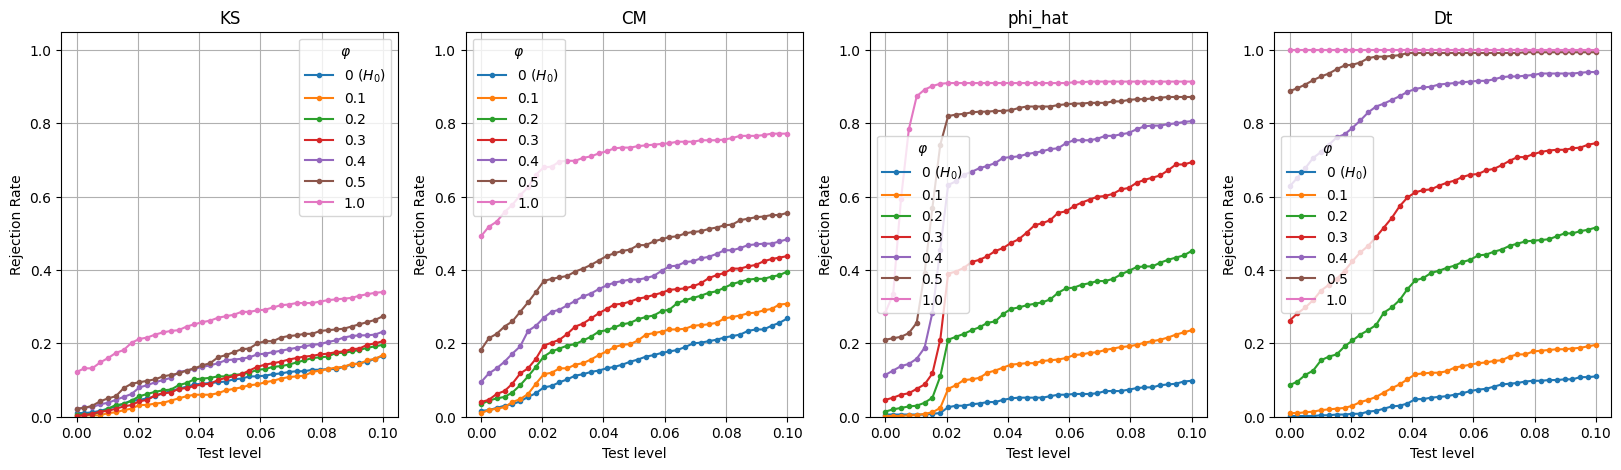

In [68]:
samplesize = 40

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_alpha_alpha(df_ser_dep_w, 'KS', samplesize, onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_alpha_alpha(df_ser_dep_w, 'CM', samplesize, onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_alpha_alpha(df_ours_w, 'phi_hat', samplesize, onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_alpha_alpha(df_ours_w, 'Dt', samplesize)

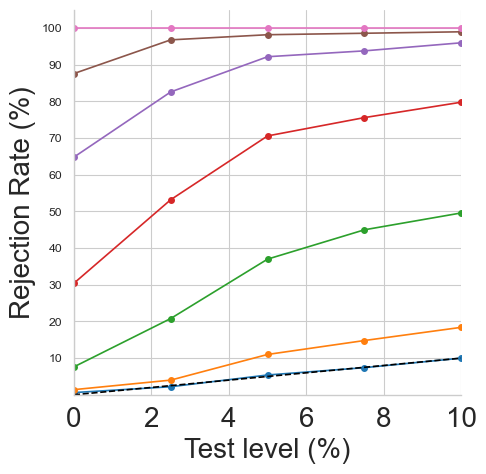

In [243]:
samplesize = 40
plt.figure(figsize=(5,5))
plotting.plot_alpha_alpha(df_ours_w, 'Dt', samplesize)
plt.savefig('./plots/size_rej_rate_wasserstein.pdf', bbox_inches='tight', transparent=True,)

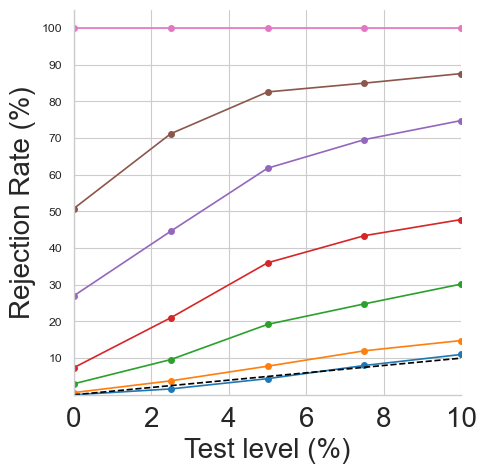

In [244]:
samplesize = 40
plt.figure(figsize=(5,5))
plotting.plot_alpha_alpha(df_ours_r, 'Dt', samplesize)
plt.savefig('./plots/size_rej_rate_R_mult_noise.pdf', bbox_inches='tight', transparent=True,)

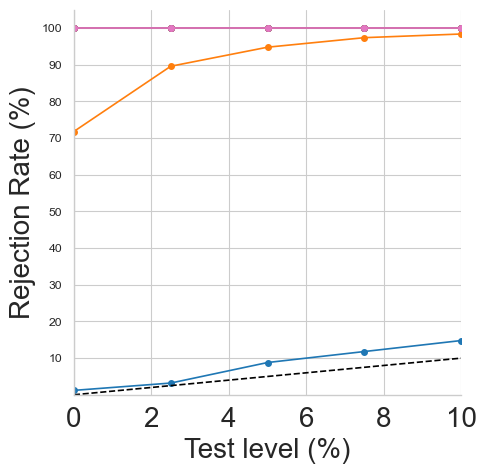

In [245]:
samplesize = 40
plt.figure(figsize=(5,5))
plotting.plot_alpha_alpha(df_logchol, 'Dt', samplesize)
plt.savefig('./plots/size_rej_rate_log_cholesky.pdf', bbox_inches='tight', transparent=True,)

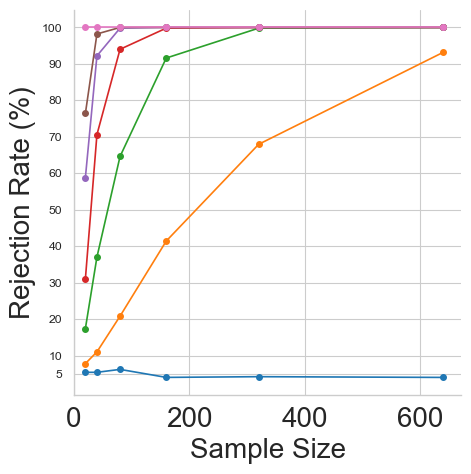

In [240]:
plt.figure(figsize=(5,5))
plotting.plot_test_for(df_ours_w, 'Dt')
plt.savefig('./plots/rejection_rates_wasserstein.pdf', bbox_inches='tight', transparent=True,)

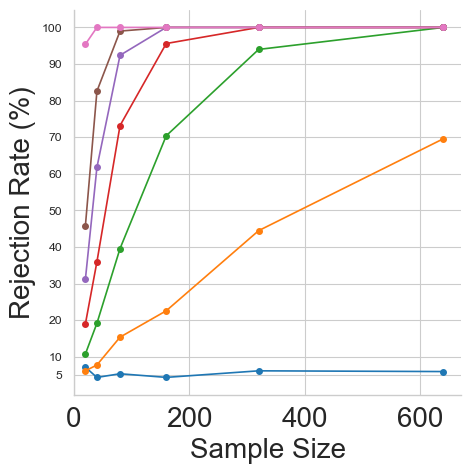

In [241]:
plt.figure(figsize=(5,5))
plotting.plot_test_for(df_ours_r, 'Dt')
plt.savefig('./plots/rejection_rates_R_mult_noise.pdf', bbox_inches='tight', transparent=True,)

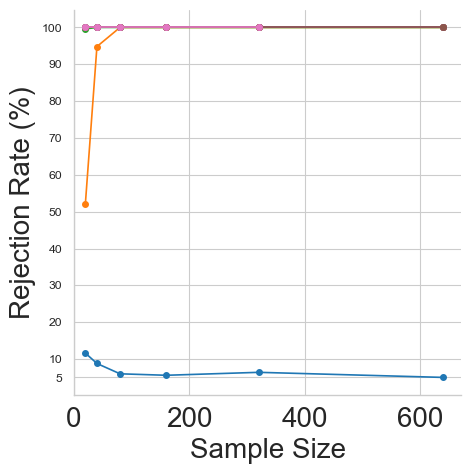

In [242]:
plt.figure(figsize=(5,5))
plotting.plot_test_for(df_logchol, 'Dt')
plt.savefig('./plots/rejection_rates_log_cholesky.pdf', bbox_inches='tight', transparent=True,)

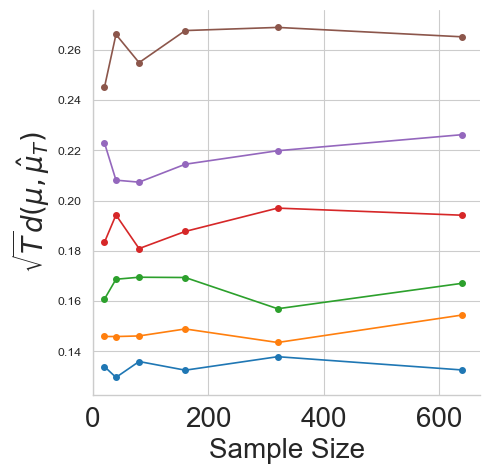

In [236]:
f, ax = plt.subplots(figsize=(5,5))
plotting.plot_sqrt_T_mu(df_ours_w)
plt.savefig('./plots/err_mu_wasserstein.pdf', bbox_inches='tight', transparent=True,)

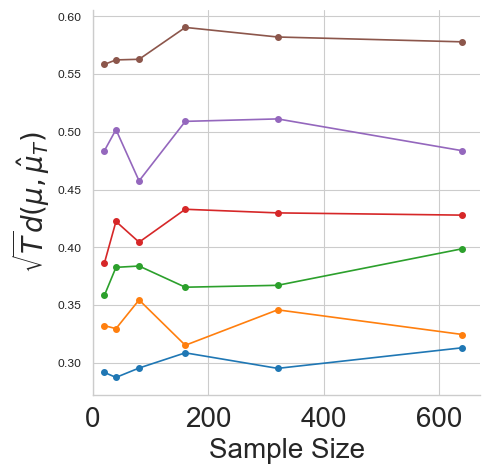

In [237]:
f, ax = plt.subplots(figsize=(5,5))
plotting.plot_sqrt_T_mu(df_ours_r)
plt.savefig('./plots/err_mu_R_mult_noise.pdf', bbox_inches='tight', transparent=True,)

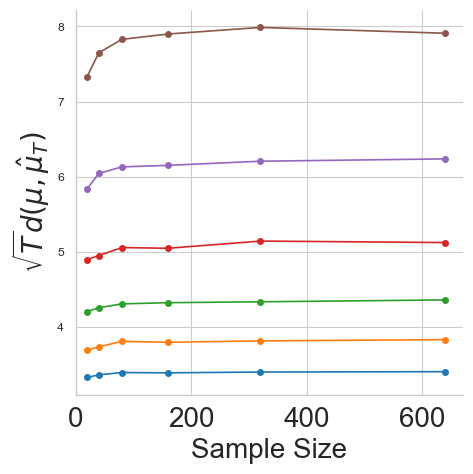

In [238]:
f, ax = plt.subplots(figsize=(5,5))
plotting.plot_sqrt_T_mu(df_logchol)
plt.savefig('./plots/err_mu_logchol.pdf', bbox_inches='tight', transparent=True,)

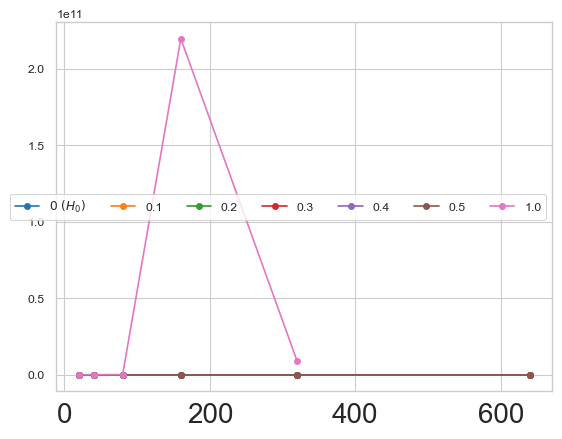

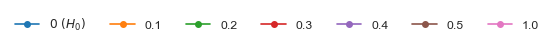

In [230]:
def make_legend(df, expand=[-5,-5,5,5]):
    for phi in np.sort(df.phi.unique()):
        sub_df = df[df['phi'] == phi].copy()
        grped = sub_df.groupby('sample_size').mean(numeric_only=True).reset_index()
        label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
        plt.plot(grped['sample_size'], grped['err'], label=label, marker='o', markersize=4)

    legend = plt.legend(ncols=df.phi.nunique())
    fig = legend.figure
    fig.canvas.draw()
    bbox = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    ax = plt.gca()
    legend_fig, legend_ax = plt.subplots(figsize=(bbox.width, bbox.height))
    legend_squared = legend_ax.legend(
        *ax.get_legend_handles_labels(), 
        bbox_to_anchor=(0, 0, 1, 1),
        bbox_transform=legend_fig.transFigure,
        frameon=False,
        fancybox=None,
        shadow=False,
        ncols=df.phi.nunique(),
        mode='expand',
    )
    legend_ax.axis('off')
    legend_fig.savefig('./plots/legend.pdf', bbox_inches='tight', bbox_extra_artists=[legend_squared], transparent=True,)


make_legend(df_logchol)

NameError: name '_df' is not defined

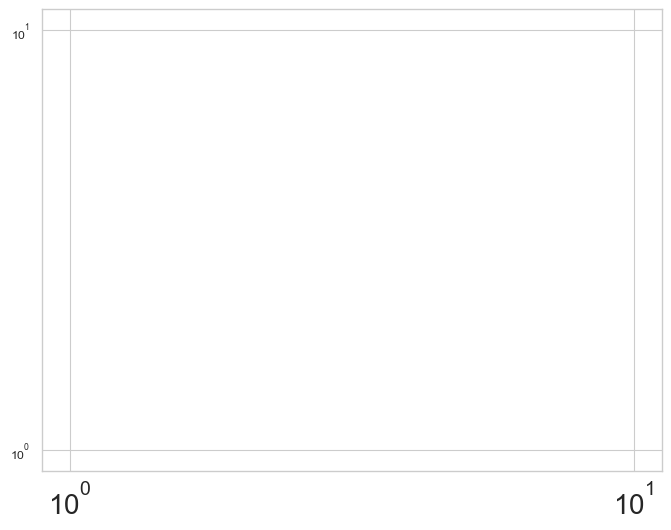

In [161]:
f, ax = plt.subplots(figsize=(8,6))
ax.set(xscale="log", yscale="log")

for phi in np.sort(df_ours_w.phi.unique()):
    # if phi == 1:
    #     continue
    
    sub_df = _df[_df['phi'] == phi]

    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    sns.lineplot(sub_df, x='sample_size', y='err', label=label)

plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.xlabel('Sample Size')
plt.ylabel(r'$d(\mu, \hat\mu)^2$')

Text(0, 0.5, '$\\left|\\hat\\varphi - \\varphi\\right|$')

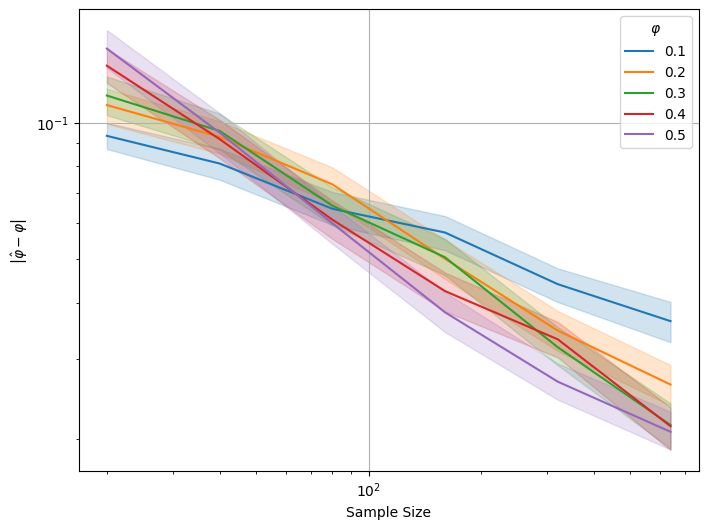

In [ ]:
f, ax = plt.subplots(figsize=(8,6))
ax.set(xscale="log", yscale="log")

for phi in np.sort(_df.phi.unique()):
    if phi == 0 or phi == 1:
        # ax.plot([], [], label=r'$0\ (H_0)$')
        continue
    sub_df = _df[_df['phi'] == phi].copy()
    sub_df['err_phi_hat'] = np.abs(sub_df['phi_hat'] - phi) + 1e-20

    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    sns.lineplot(sub_df, x='sample_size', y='err_phi_hat', label=label, ax=ax)

plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.xlabel('Sample Size')
plt.ylabel(r'$\left|\hat\varphi - \varphi\right|$')

In [ ]:
target_T = 100
true_size = np.linspace(0, 1, 40)

for phi in np.sort(_df['phi'].unique()):
    sub_df = _df[(_df['sample_size'] == target_T) & (_df['phi'] == phi)].copy()
    _M = sub_df.shape[0]

    rejection_rate = (np.repeat((np.abs(sub_df['Dt'] - sub_df['boot_mean_Dt']) / sub_df['boot_sig_Dt']).values,true_size.shape[0]).reshape((true_size.shape[0], _M)) > np.repeat(norm.ppf(1 - true_size/2), _M).reshape((true_size.shape[0], _M))).mean(axis=1)

    crit_Dt_lo = compute_critical_val(_df, 'quantiles_Dt', alpha/2)
    crit_Dt_hi = compute_critical_val(_df, 'quantiles_Dt', 1 - alpha/2)

    _df['rejected'] = (_df.Dt < crit_Dt_lo) | (_df.Dt > crit_Dt_hi)


    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    plt.scatter(true_size, rejection_rate, label=label, s=5)
plt.legend(title=r'$\varphi$')
plt.xlabel('Test level')
plt.ylabel('Empirical size')
plt.grid('on')


KeyError: 'boot_mean_Dt'